In [1]:
import warnings
warnings.filterwarnings('ignore')

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Lesson 4*
On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophiscated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifing common themes in customer reviews
* Discoverying the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model words
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics

## Part 1: Latent Dirchilet Allocation (LDA) Models
<a id="#p1"></a>

LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Part 2: Estimating LDA Models with Gensim
<a id="#p1"></a>

### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [70]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd
import matplotlib.pyplot as plt

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [10]:
path = './data/'

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [11]:
titles = [t[:-4] for t in os.listdir(path)]

In [12]:
titles[:5]

['CBronte_Jane0002',
 'CBronte_Jane0000',
 'CBronte_Jane0001',
 'Austen_Emma0001',
 'Austen_Emma0000']

In [13]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs', 'miss', 'sir']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [14]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

### Author DataFrame



In [15]:
df = pd.DataFrame(index=titles)

In [16]:
df.head()

""
CBronte_Jane0002
CBronte_Jane0000
CBronte_Jane0001
Austen_Emma0001
Austen_Emma0000


In [17]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [18]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [19]:
df.author.value_counts()

1    3
0    3
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [30]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            tokens = tokenize(str(text))
            yield tokens

### Gensim LDA Topic Modeling

In [31]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [32]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.85)

In [33]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [52]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 3,
                   passes=10,
                   workers=4
                  )

In [53]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [54]:
topics = [' '.join(t[2:5]) for t in words]

In [55]:
print(topics[0])

thought hour like


## Part 3: Interpret LDA Results
<a id="#p3"></a>

### Topic Distance Visualization

In [56]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [57]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1     -0.093650  0.0       1        1  51.313175
0      0.086280  0.0       2        1  46.165993
2      0.007371  0.0       3        1   2.520835, topic_info=  Category       Freq     Term      Total  loglift  logprob
1  Default  23.000000     like  23.000000   6.0000   6.0000
2  Default  14.000000    think  14.000000   5.0000   5.0000
0  Default  12.000000      day  12.000000   4.0000   4.0000
4  Default   8.000000      way   8.000000   3.0000   3.0000
3  Default  10.000000  thought  10.000000   2.0000   2.0000
5  Default   6.000000     hour   6.000000   1.0000   1.0000
1   Topic1  19.974838     like  23.190968   0.5179  -0.6558
4   Topic1   6.056072      way   8.341652   0.3470  -1.8492
3   Topic1   4.413923  thought  10.180681  -0.1685  -2.1655
5   Topic1   2.483820     hour   6.476196  -0.2911  -2.7405
0   Topic1   3.069931      day  12.021214  -0.6978  -2.5286
2   Topic1   2.486296    think  14.789289  -1.1159  -2.7395
2   Topic2  11.989195    think  14.789289   0.5630  -1.0606
0   Topic2   8.635633      day  12.021214   0.4422  -1.3887
5   Topic2   3.675839     hour   6.476196   0.2066  -2.2428
3   Topic2   5.451603  thought  10.180681   0.1483  -1.8487
4   Topic2   1.970143      way   8.341652  -0.6702  -2.8665
1   Topic2   2.902081     like  23.190968  -1.3054  -2.4791
5   Topic3   0.316537     hour   6.476196   0.6621  -1.7872
4   Topic3   0.315437      way   8.341652   0.4055  -1.7907
3   Topic3   0.315155  thought  10.180681   0.2054  -1.7916
0   Topic3   0.315649      day  12.021214   0.0408  -1.7900
2   Topic3   0.313799    think  14.789289  -0.1723  -1.7959
1   Topic3   0.314049     like  23.190968  -0.6214  -1.7951, token_table=      Topic      Freq     Term
term                          
0         1  0.249559      day
0         2  0.748676      day
5         1  0.308823     hour
5         2  0.617647     hour
1         1  0.862405     like
1         2  0.129361     like
2         1  0.135233    think
2         2  0.811398    think
3         1  0.392901  thought
3         2  0.491126  thought
4         1  0.719282      way
4         2  0.239761      way, R=6, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

### Overall Model / Documents

In [58]:
len(topics)

3

In [59]:
distro = [lda[d] for d in corpus]

In [60]:
distro[0]

[(0, 0.027573157), (1, 0.94966704), (2, 0.022759818)]

In [63]:
def update(doc):
        d_dist = {k:0 for k in range(0,3)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [64]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [65]:
df.head()

,thought hour like,thought day think,way thought like,author
CBronte_Jane0002,0.027573,0.949667,0.022760,CBronte
CBronte_Jane0000,0.539689,0.429277,0.031034,CBronte
CBronte_Jane0001,0.055227,0.901606,0.043167,CBronte
Austen_Emma0001,0.497303,0.479713,0.022984,Austen
Austen_Emma0000,0.934521,0.034258,0.031221,Austen


In [66]:
df.groupby('author').mean()

,thought hour like,thought day think,way thought like
author,,,
Austen,0.679724,0.296783,0.023493
CBronte,0.207496,0.760183,0.032320


## can we see if one author focuses more on men than women? or vice verca? - Ned

* use spacy for text pre processing
* extract the Named entitities from the documents using Spacy
* create unique list of names from authors
* label the names with genders (by hand or use US census name list)
* customize your processing to replace proper name with your gender from previous step's lookup table
* then follow the rest of LDA flow

## Part 4: Selecting the Number of Topics
<a id="#p4"></a>

In [77]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = doc_stream(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [99]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

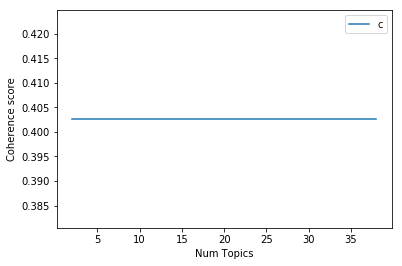

In [100]:
# Show graph
# looking for elbow, to pick best number of topics (this one shows nothing because so little data)

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [101]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4026
Num Topics = 8  has Coherence Value of 0.4026
Num Topics = 14  has Coherence Value of 0.4026
Num Topics = 20  has Coherence Value of 0.4026
Num Topics = 26  has Coherence Value of 0.4026
Num Topics = 32  has Coherence Value of 0.4026
Num Topics = 38  has Coherence Value of 0.4026


## Additional Resources
## Resources

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)

In [107]:
import spacy

nlp = spacy.load("en")

In [108]:
test = "ned asked me a question about England today."

In [109]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

ned ne VERB
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [110]:
for ent in doc.ents:
    print(ent.text, ent.label_)

England GPE
today DATE


In [116]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            
            yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            if ent.label == 'PERSON':
                ppl.append(end.txt)
                
    return set(ppl)

In [117]:
people = get_people(doc_stream(path))

In [120]:
list(people)

[]